# Parsing data directly from Google using BeautifulSoup and performing LDA

In [1]:
import warnings
warnings.filterwarnings("ignore")

# !pip install bs4
import urllib.request
from bs4 import BeautifulSoup
query = input("Enter company name ")
query = query.replace(" ","+")
url = "http://www.google.com/search?q="+str(query)
print (url)
req = urllib.request.Request(url, headers={'User-Agent' : "Magic Browser"})
response = urllib.request.urlopen( req )
html = response.read()
soup = BeautifulSoup(html, 'html.parser')
import re
all_links=[]
for link in soup.findAll('a'):
    all_links.append(link.get('href'))
# aspx_links=soup.findAll('a', attrs={'href': re.compile(".aspx")})
# aspx_links = [str(x) for x in aspx_links]
# import re
# links=[]
# for x in aspx_links:
#     m = re.search('https:(.+?)aspx', x)
#     if m:
#         found = m.group(1)
#     links.append(found)
# links= list(set(links))
# final_links = []

Enter company name corona virus
http://www.google.com/search?q=corona+virus


In [2]:
print(len(all_links))
all_links[0]

62


'/?sa=X&ved=0ahUKEwjn5bLeyL3pAhXk6XMBHRqaD_AQOwgC'

In [3]:
imp_links = []
for x in all_links:
    if x.startswith("/url"):
        imp_links.append(x)

In [4]:
print(len(imp_links))
imp_links[0]

41


'/url?q=https://timesofindia.indiatimes.com/india/live-updates-lockdown-4-guidelines-and-coronavirus-in-india/liveblog/75796010.cms&sa=U&ved=2ahUKEwjn5bLeyL3pAhXk6XMBHRqaD_AQ0PADMAF6BAgKEAI&usg=AOvVaw2CYt-tNJxGbAE0g2jIJf8F'

In [5]:
final_links = []
for x in imp_links:
    final_links.append("https://google.com"+x)

In [6]:
final_links[0]

'https://google.com/url?q=https://timesofindia.indiatimes.com/india/live-updates-lockdown-4-guidelines-and-coronavirus-in-india/liveblog/75796010.cms&sa=U&ved=2ahUKEwjn5bLeyL3pAhXk6XMBHRqaD_AQ0PADMAF6BAgKEAI&usg=AOvVaw2CYt-tNJxGbAE0g2jIJf8F'

In [7]:
text=[]
for i in range(len(final_links)):
    req = urllib.request.Request(final_links[i],headers = {'User-Agent' : 'Magic Browser'})
    response = urllib.request.urlopen(req)
    html = response.read()
    soup = BeautifulSoup(html,'lxml')
    for j in range(len(soup.find_all('p'))):
        text.append(soup.find_all('p')[j].get_text())

In [8]:
len(text)

2677

In [9]:
#NLTK for cleaning
from nltk.corpus import stopwords
from string import punctuation
stuff_to_be_removed = list(stopwords.words("english"))+list(punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Devyani\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [10]:
def my_tokenizer(s):
    s = s.lower()
    text = nltk.tokenize.word_tokenize(s)
    text = [t for t in text if len(t) > 2]
    text = [lemmatizer.lemmatize(y) for y in text if y not in stuff_to_be_removed]
    text = [t for t in text if not any(c.isdigit() for c in t)]
    
    return text

final_text = [my_tokenizer(s) for s in text]

In [11]:
import gensim
from gensim.corpora import dictionary
from gensim import corpora
from pprint import pprint

id2word = corpora.Dictionary(final_text)
mycorpus = [id2word.doc2bow(s) for s in final_text]
lda_model = gensim.models.ldamodel.LdaModel(corpus=mycorpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
pprint(lda_model.print_topics())

[(0,
  '0.031*"report" + 0.014*"human" + 0.012*"health" + 0.011*"february" + '
  '0.011*"protein" + 0.009*"response" + 0.009*"january" + 0.008*"cell" + '
  '0.007*"virus" + 0.007*"also"'),
 (1,
  '0.014*"minister" + 0.011*"delhi" + 0.010*"key" + 0.010*"material" + '
  '0.010*"train" + 0.009*"migrant" + 0.008*"guideline" + 0.008*"genome" + '
  '0.008*"chief" + 0.008*"worker"'),
 (2,
  '0.038*"case" + 0.028*"coronavirus" + 0.016*"state" + 0.015*"disease" + '
  '0.013*"virus" + 0.013*"death" + 0.013*"new" + 0.012*"may" + '
  '0.012*"lockdown" + 0.012*"number"'),
 (3,
  '0.051*"situation" + 0.025*"march" + 0.020*"april" + 0.015*"read" + '
  '0.014*"news" + 0.013*"download" + 0.011*"latest" + 0.009*"medium" + '
  '0.008*"india" + 0.008*"release"')]


In [13]:
doc_lda = lda_model[mycorpus]

In [14]:
print('\nPerplexity: ', lda_model.log_perplexity(mycorpus)) 
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.302384770444302

Coherence Score:  0.4640190349440943


In [15]:
import os
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, mycorpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.285225 -0.033891       1        1  42.597492
0     -0.060057  0.207328       2        1  26.752714
1     -0.124632 -0.194281       3        1  17.740679
3     -0.100536  0.020845       4        1  12.909115, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
1575  Default  195.000000         situation  195.000000  30.0000  30.0000
34    Default  477.000000              case  477.000000  29.0000  29.0000
293   Default  245.000000            report  245.000000  28.0000  28.0000
28    Default  365.000000       coronavirus  365.000000  27.0000  27.0000
1593  Default   95.000000             march   95.000000  26.0000  26.0000
1569  Default   78.000000             april   78.000000  25.0000  25.0000
443   Default  187.000000           disease  187.000000  24.0000  24.0000
521   Default  109.000000             human  109.000000  23.0000  23.0000
179   Default  165.000000             death  165.000000  22.0000  22.0000
3     Default  155.000000               may  155.000000  21.0000  21.0000
17    Default  154.000000          lockdown  154.000000  20.0000  20.0000
286   Default   72.000000          minister   72.000000  19.0000  19.0000
38    Default  147.000000            number  147.000000  18.0000  18.0000
167   Default  234.000000             state  234.000000  17.0000  17.0000
749   Default   56.000000              read   56.000000  16.0000  16.0000
183   Default  164.000000               new  164.000000  15.0000  15.0000
361   Default   54.000000              news   54.000000  14.0000  14.0000
698   Default   86.000000          february   86.000000  13.0000  13.0000
39    Default  134.000000          positive  134.000000  12.0000  12.0000
45    Default  133.000000             total  133.000000  11.0000  11.0000
58    Default  127.000000          reported  127.000000  10.0000  10.0000
90    Default   59.000000             delhi   59.000000   9.0000   9.0000
1475  Default   48.000000          download   48.000000   8.0000   8.0000
675   Default   89.000000           protein   89.000000   7.0000   7.0000
2689  Default   54.000000               key   54.000000   6.0000   6.0000
525   Default   72.000000          response   72.000000   5.0000   5.0000
1544  Default   52.000000          material   52.000000   4.0000   4.0000
141   Default   52.000000             train   52.000000   3.0000   3.0000
20    Default  112.000000            people  112.000000   2.0000   2.0000
702   Default   69.000000           january   69.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
240    Topic4   40.154610            latest   40.889290   2.0291  -4.5473
359    Topic4   33.095284            medium   33.808964   2.0259  -4.7407
637    Topic4   29.118721           release   29.851620   2.0224  -4.8687
1216   Topic4   28.477221  director-general   29.197920   2.0222  -4.8910
1113   Topic4   28.717600       information   29.473457   2.0213  -4.8826
1143   Topic4   24.055370          briefing   24.780882   2.0175  -5.0597
1513   Topic4   22.311728              hand   23.030605   2.0155  -5.1350
354    Topic4   22.539467           article   23.283907   2.0147  -5.1248
1061   Topic4   21.755678              free   22.495657   2.0138  -5.1602
1125   Topic4   20.479479         subscribe   21.218611   2.0118  -5.2207
65     Topic4   20.425804          continue   21.164860   2.0117  -5.2233
477    Topic4   20.491226       development   21.273598   2.0098  -5.2201
375    Topic4   17.699966           updated   18.427258   2.0070  -5.3665
377    Topic4   16.158005          business   16.928480   2.0007  -5.4577
366    Topic4   15.037227             video   15.756866   2.0005  -5.5296
3378   Topic4   17.348946               see   18.208118   1.9989  -5.3866
1324   

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mycorpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=mycorpus, texts=final_text, start=2, limit=40, step=6)

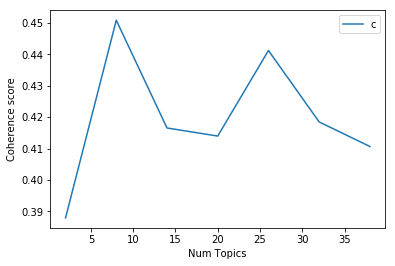

In [18]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3879
Num Topics = 8  has Coherence Value of 0.4509
Num Topics = 14  has Coherence Value of 0.4165
Num Topics = 20  has Coherence Value of 0.414
Num Topics = 26  has Coherence Value of 0.4412
Num Topics = 32  has Coherence Value of 0.4185
Num Topics = 38  has Coherence Value of 0.4106


In [20]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"health" + 0.012*"coronavirus" + 0.011*"lockdown" + 0.010*"sunday" + '
  '0.008*"case" + 0.008*"till" + 0.008*"virus" + 0.007*"people" + 0.007*"may" '
  '+ 0.007*"state"'),
 (1,
  '0.012*"virus" + 0.009*"case" + 0.009*"health" + 0.008*"key" + '
  '0.008*"material" + 0.007*"state" + 0.007*"coronaviruses" + 0.007*"day" + '
  '0.006*"account" + 0.006*"class"'),
 (2,
  '0.016*"coronavirus" + 0.013*"mumbai" + 0.013*"may" + 0.009*"virus" + '
  '0.008*"chief" + 0.008*"minister" + 0.008*"health" + 0.007*"mha" + '
  '0.007*"day" + 0.007*"hospital"'),
 (3,
  '0.013*"march" + 0.013*"india" + 0.012*"disease" + 0.011*"case" + '
  '0.010*"read" + 0.009*"news" + 0.008*"situation" + 0.008*"coronavirus" + '
  '0.008*"download" + 0.007*"country"'),
 (4,
  '0.030*"coronaviruses" + 0.012*"virus" + 0.010*"district" + 0.010*"medium" + '
  '0.010*"bat" + 0.010*"day" + 0.009*"cause" + 0.008*"trial" + '
  '0.008*"coronavirus" + 0.008*"human"'),
 (5,
  '0.048*"case" + 0.015*"positive" + 0.015*"num

In [21]:
import pandas as pd
def format_topics_sentences(ldamodel=lda_model, corpus=mycorpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=mycorpus, texts=final_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5623,"march, india, disease, case, read, news, situa...",[india]
1,1,3.0,0.7082,"march, india, disease, case, read, news, situa...","[time, india]"
2,2,2.0,0.5054,"coronavirus, mumbai, may, virus, chief, minist...","[time, india, may, ist]"
3,3,0.0,0.1250,"health, coronavirus, lockdown, sunday, case, t...",[]
4,4,0.0,0.9687,"health, coronavirus, lockdown, sunday, case, t...","[centre, sunday, extended, nationwide, lockdow..."
5,5,0.0,0.7077,"health, coronavirus, lockdown, sunday, case, t...","[tracking, coronavirus]"
6,6,5.0,0.7090,"case, positive, number, total, death, state, k...","[assam, govt, issue, revised, guideline, lockd..."
7,7,5.0,0.6184,"case, positive, number, total, death, state, k...","[tamil, nadu, people, test, positive, taking, ..."
8,8,3.0,0.7026,"march, india, disease, case, read, news, situa...","[last, hour, total, patient, reported, cured, ..."
9,9,6.0,0.9635,"report, situation, disease, coronavirus, virus...","[centre, asked, impose, curfew, anyway, lockdo..."


In [22]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9919,"health, coronavirus, lockdown, sunday, case, till, virus, people, may, state","[december, wuhan, central, hospital, sent, bronchoalveolar, lavage, fluid, bal, sample, unresolv..."
1,1.0,0.9875,"virus, case, health, key, material, state, coronaviruses, day, account, class","[may, approximately, billion, learner, currently, affected, due, school, closure, response, pand..."
2,2.0,0.9851,"coronavirus, mumbai, may, virus, chief, minister, health, mha, day, hospital","[drastic, action, aimed, containing, outbreak, taken, china, severity, outbreak, became, apparen..."
3,3.0,0.9863,"march, india, disease, case, read, news, situation, coronavirus, download, country","[surface, may, decontaminated, number, solution, within, one, minute, exposure, disinfectant, st..."
4,4.0,0.9856,"coronaviruses, virus, district, medium, bat, day, cause, trial, coronavirus, human","[south, korea, lgbtq, community, fear, singling, community, would, increase, discrimination, har..."
5,5.0,0.9873,"case, positive, number, total, death, state, karnataka, health, new, january","[case, refer, number, people, tested, whose, test, confirmed, positive, according, official, pro..."
6,6.0,0.9817,"report, situation, disease, coronavirus, virus, april, february, protein, rna, spike","[january, center, disease, control, prevention—the, leading, public, health, institute, u.s., go..."
7,7.0,0.9749,"case, coronavirus, death, state, genome, rise, reported, pradesh, total, new","[outbreak, confirmed, spread, italy, january, two, chinese, tourist, tested, positive, rome, cas..."


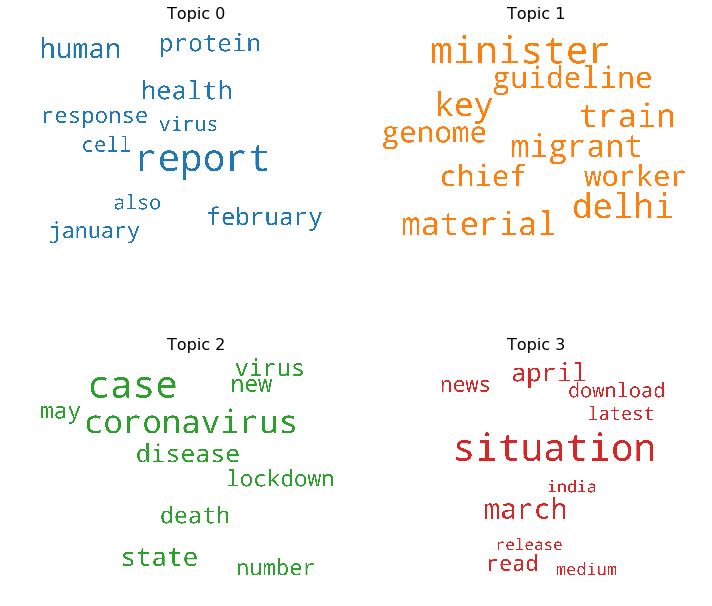

In [23]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stuff_to_be_removed,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

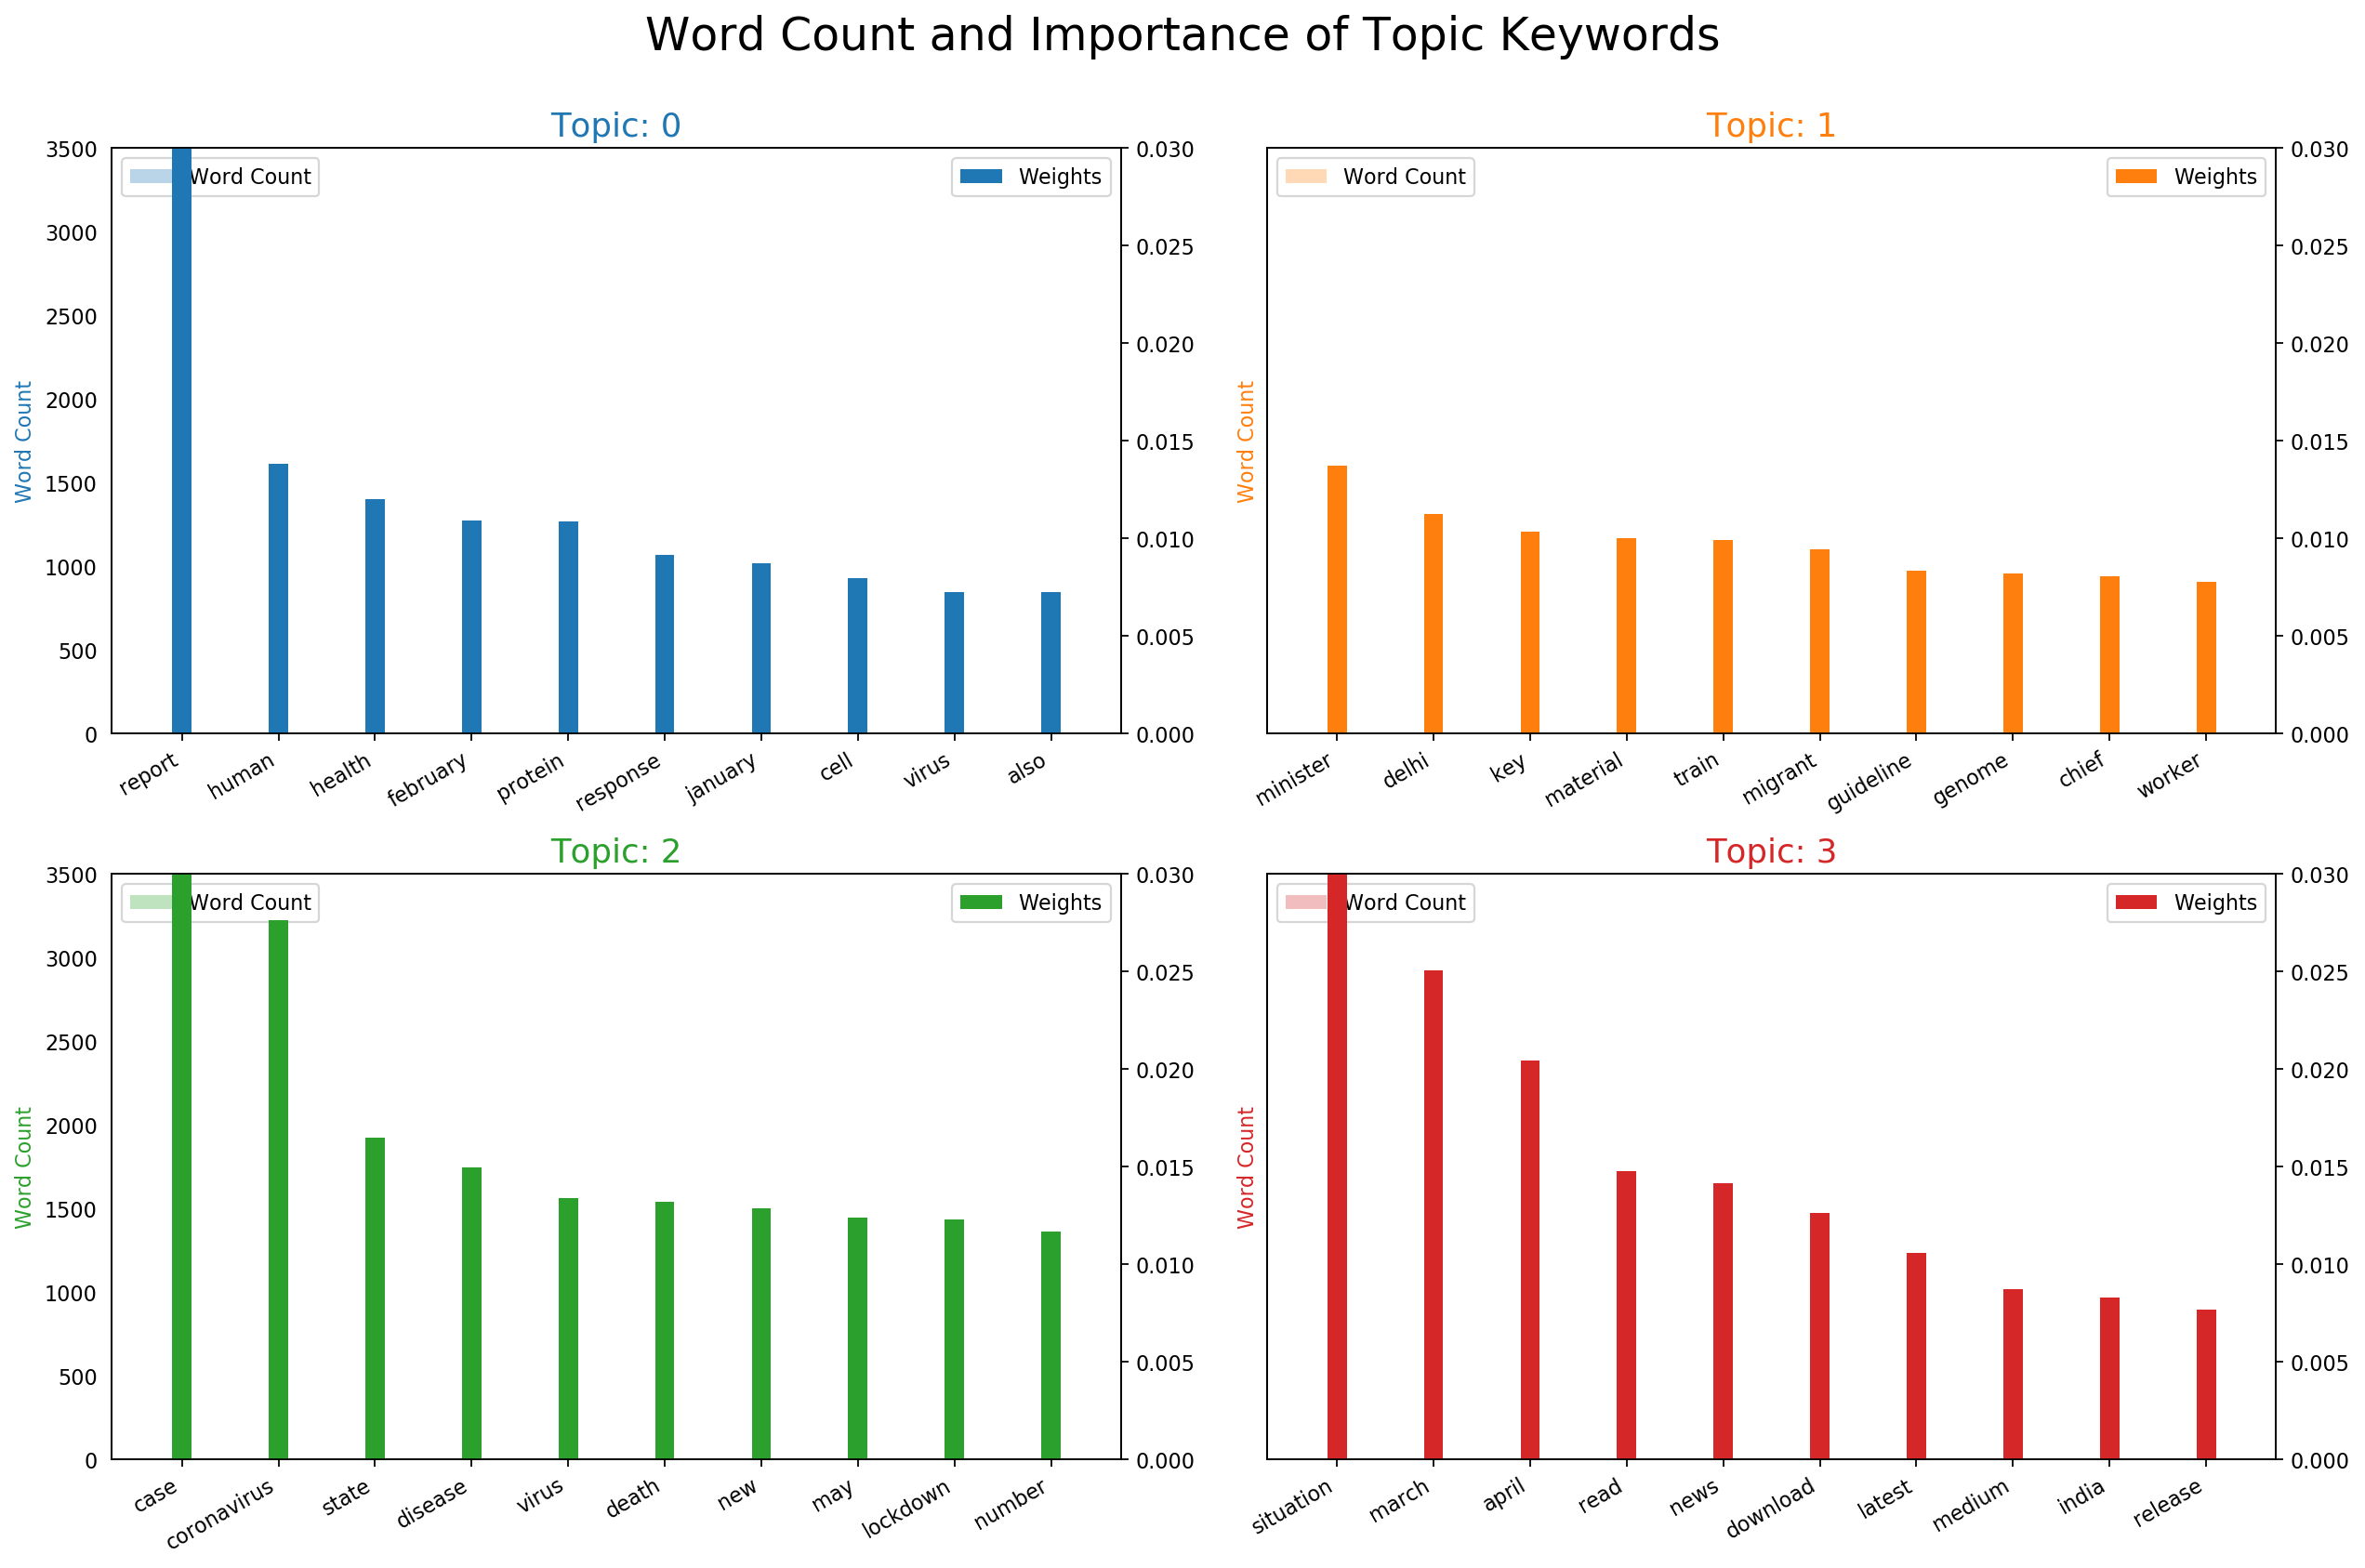

In [24]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()